## **Class Activation Maps (CAM) and Saliency Maps are techniques used to visualize and understand the important regions of an input image that contribute to the prediction of a neural network, especially Convolutional Neural Networks (CNNs).**


* ### CAM produces a heatmap that highlights discriminative regions of an image related to a specific class by associating importance weights with different spatial locations in the image. It weights the feature maps based on the importance values and produces a weighted combination.


* ### Saliency Maps highlight high-gradient areas that significantly impact the model's output. Saliency Maps are based on gradient calculations between the input image and the predicted class, focusing on pixel-wise sensitivity.

In [1]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.applications.efficientnet import EfficientNetB0,EfficientNetB1,EfficientNetB2,EfficientNetB3,EfficientNetB4
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss, jaccard_score
import numpy as np
import os
from PIL import Image
from shutil import copyfile  # Import the copyfile function
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 

In [2]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Define the dataset path and output paths
dataset_path = "/kaggle/input/pumpkin-leaf-diseases-dataset-from-bangladesh/Pumpkin Leaf Diseases Dataset From Bangladesh/Original Dataset"
train_output_path = "/kaggle/working/train"
test_output_path = "/kaggle/working/test"
val_output_path = "/kaggle/working/validation"

# Seed for reproducibility
manual_seed = 42

# Function to create directories if they don't exist
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to copy files from source to destination
def copy_files(file_list, src_dir, dest_dir):
    for file in file_list:
        src_file = os.path.join(src_dir, file)
        dest_file = os.path.join(dest_dir, file)
        shutil.copy(src_file, dest_file)

# Get directories within the dataset path
class_directories = os.listdir(dataset_path)

# Create directories for train, validation, and test datasets
create_directory(train_output_path)
create_directory(val_output_path)
create_directory(test_output_path)

# Split and distribute the images into train, validation, and test sets
for class_dir in class_directories:
    class_path = os.path.join(dataset_path, class_dir)
    image_files = os.listdir(class_path)

    # Split image files into train, validation, and test sets
    train_files, val_test_files = train_test_split(image_files, train_size=0.8, random_state=manual_seed)
    val_files, test_files = train_test_split(val_test_files, train_size=0.5, random_state=manual_seed)

    # Create class-specific directories in train, validation, and test output paths
    create_directory(os.path.join(train_output_path, class_dir))
    create_directory(os.path.join(val_output_path, class_dir))
    create_directory(os.path.join(test_output_path, class_dir))

    # Copy files to the respective directories
    copy_files(train_files, class_path, os.path.join(train_output_path, class_dir))
    copy_files(val_files, class_path, os.path.join(val_output_path, class_dir))
    copy_files(test_files, class_path, os.path.join(test_output_path, class_dir))

# Set random seed
random.seed(manual_seed)


# **Dataset Describtion**
* train - 70%
* test - 20%
* validation - 10%

In [3]:
# Define the paths to our train, validation, and test datasets
train_data_dir =  '/kaggle/working/train'
test_data_dir = '/kaggle/working/test'
validation_data_dir = '/kaggle/working/validation'

# Image dimensions
IMG_WIDTH, IMG_HEIGHT = 299, 299
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)  # RGB images


# **Data generators**

In [4]:
# Data generators for RGB images
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)



# Define data generators for RGB images with augmentation
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotation angle range
    width_shift_range=0.2,  # Horizontal shift range
    height_shift_range=0.2,  # Vertical shift range
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Random zoom range
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # Do not flip images vertically
    fill_mode='nearest'  # Fill mode for newly created pixels
)

# Generate augmented data for training
train_generator = train_datagen_augmented.flow_from_directory(
    train_data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=10,
    class_mode='categorical',
  
)


# Define data generators for RGB images with augmentation
test_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotation angle range
    width_shift_range=0.2,  # Horizontal shift range
    height_shift_range=0.2,  # Vertical shift range
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Random zoom range
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # Do not flip images vertically
    fill_mode='nearest'  # Fill mode for newly created pixels
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=8,
    class_mode='categorical',
    shuffle=False,
   )

# Define data generators for RGB images with augmentation
validation_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotation angle range
    width_shift_range=0.2,  # Horizontal shift range
    height_shift_range=0.2,  # Vertical shift range
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Random zoom range
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # Do not flip images vertically
    fill_mode='nearest'  # Fill mode for newly created pixels
)
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=8,
    class_mode='categorical',
    shuffle=True,
   
)




Found 1600 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


# **{'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}**

In [5]:
class_indices = train_generator.class_indices
print(class_indices)

{'Bacterial Leaf Spot': 0, 'Downy Mildew': 1, 'Healthy Leaf': 2, 'Mosaic Disease': 3, 'Powdery_Mildew': 4}


# **Number of images for each class in the training dataset**

In [6]:
# Count the number of images for each class in the training dataset
classes = os.listdir(train_data_dir)
for class_name in classes:
    class_path = os.path.join(train_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of images: {num_images}")


Class: Powdery_Mildew, Number of images: 320
Class: Downy Mildew, Number of images: 320
Class: Bacterial Leaf Spot, Number of images: 320
Class: Healthy Leaf, Number of images: 320
Class: Mosaic Disease, Number of images: 320


# **Check the shape of the images in Train Generator**

In [7]:
# Get a batch of images and labels from the train_generator
batch = next(train_generator)

# Iterate through the batch to check image shapes
for i in range(len(batch[0])):
    img = batch[0][i]  # Image data
    label = batch[1][i]  # Image label
    
    # Get image shape and channels
    height, width, channels = img.shape
    
    # Display image shape and channels
    print(f"Image {i+1} - Shape: {width}x{height}x{channels}, Label: {label}")


Image 1 - Shape: 299x299x3, Label: [0. 1. 0. 0. 0.]
Image 2 - Shape: 299x299x3, Label: [0. 1. 0. 0. 0.]
Image 3 - Shape: 299x299x3, Label: [0. 0. 0. 0. 1.]
Image 4 - Shape: 299x299x3, Label: [0. 0. 0. 0. 1.]
Image 5 - Shape: 299x299x3, Label: [0. 0. 1. 0. 0.]
Image 6 - Shape: 299x299x3, Label: [0. 0. 0. 1. 0.]
Image 7 - Shape: 299x299x3, Label: [1. 0. 0. 0. 0.]
Image 8 - Shape: 299x299x3, Label: [0. 1. 0. 0. 0.]
Image 9 - Shape: 299x299x3, Label: [0. 1. 0. 0. 0.]
Image 10 - Shape: 299x299x3, Label: [0. 0. 0. 0. 1.]


# **Number of images for each class in the testing dataset**

In [8]:
# Count the number of images for each class in the testing dataset
classes = os.listdir(test_data_dir)
for class_name in classes:
    class_path = os.path.join(test_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of images: {num_images}")


Class: Powdery_Mildew, Number of images: 40
Class: Downy Mildew, Number of images: 40
Class: Bacterial Leaf Spot, Number of images: 40
Class: Healthy Leaf, Number of images: 40
Class: Mosaic Disease, Number of images: 40


# **Check the shape of the images in Test Generator**

In [9]:
# Get a batch of images and labels from the test_generator
batch = next(test_generator)

# Iterate through the batch to check image shapes
for i in range(len(batch[0])):
    img = batch[0][i]  # Image data
    label = batch[1][i]  # Image label
    
    # Get image shape and channels
    height, width, channels = img.shape
    
    # Display image shape and channels
    print(f"Image {i+1} - Shape: {width}x{height}x{channels}, Label: {label}")


Image 1 - Shape: 299x299x3, Label: [1. 0. 0. 0. 0.]
Image 2 - Shape: 299x299x3, Label: [1. 0. 0. 0. 0.]
Image 3 - Shape: 299x299x3, Label: [1. 0. 0. 0. 0.]
Image 4 - Shape: 299x299x3, Label: [1. 0. 0. 0. 0.]
Image 5 - Shape: 299x299x3, Label: [1. 0. 0. 0. 0.]
Image 6 - Shape: 299x299x3, Label: [1. 0. 0. 0. 0.]
Image 7 - Shape: 299x299x3, Label: [1. 0. 0. 0. 0.]
Image 8 - Shape: 299x299x3, Label: [1. 0. 0. 0. 0.]


# **Number of images for each class in the validation dataset**

In [10]:
# Count the number of images for each class in the testing dataset
classes = os.listdir(validation_data_dir)
for class_name in classes:
    class_path = os.path.join(validation_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of images: {num_images}")


Class: Powdery_Mildew, Number of images: 40
Class: Downy Mildew, Number of images: 40
Class: Bacterial Leaf Spot, Number of images: 40
Class: Healthy Leaf, Number of images: 40
Class: Mosaic Disease, Number of images: 40


# **Check the shape of the images in Validation Generator**

In [11]:
# Get a batch of images and labels from the validation_generator
batch = next(validation_generator)

# Iterate through the batch to check image shapes
for i in range(len(batch[0])):
    img = batch[0][i]  # Image data
    label = batch[1][i]  # Image label
    
    # Get image shape and channels
    height, width, channels = img.shape
    
    # Display image shape and channels
    print(f"Image {i+1} - Shape: {width}x{height}x{channels}, Label: {label}")


Image 1 - Shape: 299x299x3, Label: [0. 0. 1. 0. 0.]
Image 2 - Shape: 299x299x3, Label: [0. 0. 1. 0. 0.]
Image 3 - Shape: 299x299x3, Label: [0. 0. 0. 1. 0.]
Image 4 - Shape: 299x299x3, Label: [0. 1. 0. 0. 0.]
Image 5 - Shape: 299x299x3, Label: [0. 0. 0. 0. 1.]
Image 6 - Shape: 299x299x3, Label: [0. 0. 0. 1. 0.]
Image 7 - Shape: 299x299x3, Label: [0. 0. 0. 0. 1.]
Image 8 - Shape: 299x299x3, Label: [1. 0. 0. 0. 0.]


# **Check for GPU availability**

In [12]:
# Check for GPU availability
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

# Set TensorFlow to use the GPU device
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    print("GPU device configured")
else:
    print("No GPU device found")

GPU is available
GPU device configured


# **Model checkpoint**

In [13]:
# Update the filepath to end with '.keras'
checkpoint_path = "/kaggle/working/InceptionResNetV2/model_best.keras"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 save_best_only=True,  # Save only the best model
                                                 monitor="val_accuracy",   # Monitor validation accuracy
                                                 mode="max",           # Save the model when validation accuracy is maximized
                                                 verbose=1)


In [14]:
# from tensorflow.keras.callbacks import ModelCheckpoint
# model_dir = '/kaggle/working/InceptionResNetV2'

# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

# checkpoint_path = model_dir + '/cp.ckpt'
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=False,
#                                                  save_best_only=True,  # Save only the best model
#                                                  monitor="val_accuracy",   # Monitor validation loss
#                                                  mode="max",           # Save the model when validation loss is minimized
#                                                  verbose=1)

In [15]:
checkpoint_path

'/kaggle/working/InceptionResNetV2/model_best.keras'

> # **InceptionResNetV2 for Feature Extractor** 
## **1.** Xception


In [16]:
from tensorflow.keras import models, layers, optimizers

In [17]:
def create_model(summary=True):
    # apply transfer learning
    new_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=new_input) ##MobileNetV3Small(weights='imagenet', include_top=False, input_tensor=new_input)
    # add new classifier layers
    flat1 = Flatten()(base_model.layers[-1].output)
    output = Dense(5, activation='softmax')(flat1)  # Change to 1 for binary classification
    # define new model
    model = Model(inputs=base_model.inputs, outputs=output)
    # Modify loss function to 'weighted_binary_crossentropy'
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])  #lr = 1e-3
    if summary:
        print(model.summary())
    return model


# **Model summary**

In [18]:
model = create_model()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 305, 305,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 150, 150,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 150, 150,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 150, 150,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 152, 152,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 75, 75,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 75, 75,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 75, 75,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 75, 75,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 75, 75,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 75, 75,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 75, 75,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 75, 75,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 75, 75,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 75, 75,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 75, 75,    │     12,288 │ conv2_block2_0_r

 Total params: 7,452,229 (28.43 MB)

 Trainable params: 7,368,581 (28.11 MB)

 Non-trainable params: 83,648 (326.75 KB)

None


# **Training starts here**

In [19]:
# Train the model
history = model.fit(
    train_generator,
    batch_size=10,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[cp_callback]
    )

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728328871.163250     131 service.cc:145] XLA service 0x7b2ee4004cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728328871.163319     131 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728328959.381797     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.3182 - loss: 1.9591
Epoch 1: val_accuracy improved from -inf to 0.58500, saving model to /kaggle/working/InceptionResNetV2/model_best.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 200s 329ms/step - accuracy: 0.3188 - loss: 1.9570 - val_accuracy: 0.5850 - val_loss: 1.1192
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.5951 - loss: 1.1277
Epoch 2: val_accuracy improved from 0.58500 to 0.67500, saving model to /kaggle/working/InceptionResNetV2/model_best.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 42s 253ms/step - accuracy: 0.5954 - loss: 1.1270 - val_accuracy: 0.6750 - val_loss: 0.9467
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.6783 - loss: 0.8816
Epoch 3: val_accuracy improved from 0.67500 to 0.69500, saving model to /kaggle/working/InceptionResNetV2/model_best.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 43s 255ms/step - accuracy: 0.6784 - loss: 0.8812 - val_accuracy: 0.6950 - val_loss: 0.8450
Epoch 4/50
160/160 ━

# **Save model history in a CSV file**

In [20]:
# Save the training history
initial_epoch = 0  # or the actual initial epoch of the first training session
saved_history = {
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy'],
    # Add other metrics as needed
}
np.save("/kaggle/working/InceptionResNetV2_saved_history.npy", saved_history)

# **Again Train the loaded model**

In [21]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Set the path to the saved model
saved_model_path = '/kaggle/working/InceptionResNetV2/model_best.keras'

# Check if the model file exists
if tf.io.gfile.exists(saved_model_path):
    # Load the entire model including its weights and configurations
    loaded_model = load_model(saved_model_path)
    print("Model loaded successfully.")
else:
    print("No checkpoint file found at:", saved_model_path)


Model loaded successfully.


In [22]:
# # Load the latest checkpoint file
# latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
# print(latest_checkpoint)

# if latest_checkpoint is not None:
#     # Create a new model instance
#     loaded_model = create_model(summary=True)

#     # Load the previously saved weights and silence the warnings
#     status = loaded_model.load_weights(latest_checkpoint)
#     status.expect_partial()  # Ignore unrestored variables
# else:
#     print("No checkpoint file found in the specified directory.")

In [23]:
# Load the previous history
previous_history = np.load("/kaggle/working/InceptionResNetV2_saved_history.npy", allow_pickle=True).item()
initial_epoch = len(previous_history['loss'])
print(initial_epoch)

50


In [24]:
loaded_model.compile(optimizer=Adam(learning_rate=1e-3), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
# Train the model
#initial_epoch = 20
new_history  = loaded_model.fit(
    train_generator,
    epochs=5,
    initial_epoch=initial_epoch,
    validation_data=validation_generator,
    callbacks=[cp_callback]
    
)

# **Again save the history after using latest weights in a CSV file**

In [25]:
# # Update and save the training history
# previous_history['loss'].extend(new_history.history['loss'])
# previous_history['accuracy'].extend(new_history.history['accuracy'])
# previous_history['val_loss'].extend(new_history.history['val_loss'])
# previous_history['val_accuracy'].extend(new_history.history['val_accuracy'])
# # Repeat for other metrics as needed

# np.save("/kaggle/working/InceptionResNetV2_saved_history.npy", previous_history)

In [26]:
#previous_history

# **Accuracy and loss graph of training and validation**
## Here, No. of epochs and (xticks & yticks) will be changed

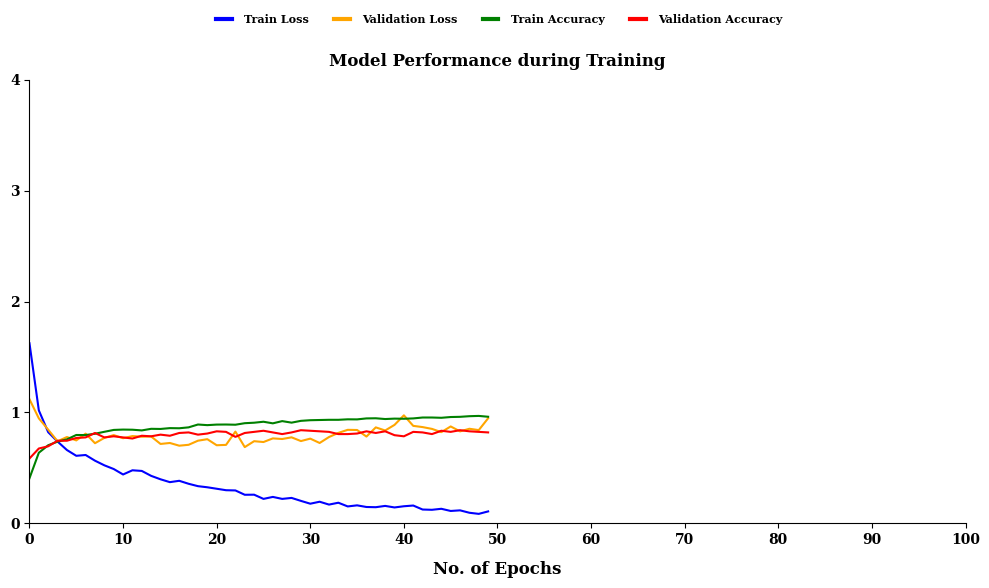

In [27]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D
import numpy as np

# Plot training & validation loss values
plt.figure(figsize=(10, 6))

# Plot Loss
train_loss, = plt.plot(previous_history['loss'], label='Train Loss', color='blue')
val_loss, = plt.plot(previous_history['val_loss'], label='Validation Loss', color='orange')
train_accuracy, = plt.plot(previous_history['accuracy'], label='Train Accuracy',  color='green')
val_accuracy, = plt.plot(previous_history['val_accuracy'], label='Validation Accuracy', color='red')
# Add a title with specified font properties
plt.title('Model Performance during Training', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12},pad=10)
# Set x-axis label with specified font properties
plt.xlabel('No. of Epochs', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})

# Set x-axis ticks font properties
#plt.xticks(np.linspace(0, len(history.history['loss']), num=6), fontname='Serif', weight='bold')

plt.xticks(np.linspace(0, 100, num=11), fontname='Serif', weight='bold')


# Set y-axis ticks font properties
plt.yticks(np.linspace(0, 4, num=5), fontname='Serif', weight='bold')

# Set the x-axis and y-axis limits
#plt.xlim(0, len(history.history['loss']))

plt.xlim(0, 100)
plt.ylim(0, 4)

# Define custom legend lines with desired line properties
legend_lines = [
    Line2D([0], [0], color='blue', lw=3),          # Train Loss
    Line2D([0], [0], color='orange', lw=3),       # Validation Loss
    Line2D([0], [0], color='green', lw=3),        # Train Accuracy
    Line2D([0], [0], color='red', lw=3)           # Validation Accuracy
]

# Place legend outside the graph by adjusting bbox_to_anchor and specifying it to be outside the axes
plt.legend(legend_lines, ['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy'],
           loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=5,
           prop={'family': 'Serif', 'weight': 'bold', 'size': 8}, frameon=False,
           handler_map={Line2D: HandlerLine2D(numpoints=5)})

# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Adjust layout to prevent cropping
plt.tight_layout()
plt.savefig('/kaggle/working/InceptionResNetV2_accuracy_graph.pdf')  # Save as pdf format
plt.show()


# **Testing starts here**

In [28]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Set the path to the saved model
saved_model_path = '/kaggle/working/InceptionResNetV2/model_best.keras'

# Check if the model file exists
if tf.io.gfile.exists(saved_model_path):
    # Load the entire model including its weights and configurations
    loaded_model = load_model(saved_model_path)
    print("Model loaded successfully.")
else:
    print("No checkpoint file found at:", saved_model_path)


Model loaded successfully.


In [29]:
# Evaluate the model on the test set
test_loss, test_acc = loaded_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8653 - loss: 0.3895
Test Accuracy: 0.8500000238418579


In [30]:
# Predict labels for the test set
predictions = loaded_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Get the index of the highest probability class
true_classes = test_generator.classes

# Display some of the predicted and true classes
print("Predicted Classes:", predicted_classes[-10:])  # Display first 10 predicted classes
print("True Classes:", true_classes[-10:])  # Display first 10 true classes


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step
Predicted Classes: [1 4 3 3 3 1 4 4 4 4]
True Classes: [4 4 4 4 4 4 4 4 4 4]


In [31]:
#true_classes

In [32]:
#predicted_classes

# **Evaluation Metircs**

In [33]:
print(f"Accuracy: {accuracy_score(true_classes, predicted_classes)}")
print(f"Precision: {precision_score(true_classes, predicted_classes,average='weighted')}")
print(f"Recall: {recall_score(true_classes, predicted_classes,average='weighted')}")
print(f"F1 Score: {f1_score(true_classes, predicted_classes,average='weighted')}")
#print(f"Log Loss: {log_loss(true_classes, predicted_classes)}")
print(f"Jaccard Score: {jaccard_score(true_classes, predicted_classes,average='weighted')}")

Accuracy: 0.85
Precision: 0.8549501661129568
Recall: 0.85
F1 Score: 0.8483808898228701
Jaccard Score: 0.7414548455701135


In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, jaccard_score

# Weighted metrics
#weighted_accuracy = accuracy_score(true_classes, predicted_classes, average='weighted')
weighted_precision = precision_score(true_classes, predicted_classes, average='weighted')
weighted_recall = recall_score(true_classes, predicted_classes, average='weighted')
weighted_f1 = f1_score(true_classes, predicted_classes, average='weighted')
#weighted_log_loss = log_loss(true_classes, predicted_classes, labels=list(set(true_classes)), eps=1e-15)
weighted_jaccard = jaccard_score(true_classes, predicted_classes, average='weighted')

# Print the results

print(f"Weighted Precision: {weighted_precision}")
print(f"Weighted Recall: {weighted_recall}")
print(f"Weighted F1 Score: {weighted_f1}")
#print(f"Weighted Log Loss: {weighted_log_loss}")
print(f"Weighted Jaccard Score: {weighted_jaccard}")


Weighted Precision: 0.8549501661129568
Weighted Recall: 0.85
Weighted F1 Score: 0.8483808898228701
Weighted Jaccard Score: 0.7414548455701135


In [35]:
# # Weighted precision, recall, and F1 score
# weighted_precision = precision_score(true_classes, predicted_classes, average='weighted')
# weighted_recall = recall_score(true_classes, predicted_classes, average='weighted')
# weighted_f1 = f1_score(true_classes, predicted_classes, average='weighted')

In [36]:
from sklearn.metrics import log_loss
import numpy as np

# Assuming predicted_classes contains probability scores for each class
# Convert predicted_classes to a one-hot encoded format
predicted_proba = np.zeros((len(true_classes), 5))  # Assuming 5 classes
predicted_proba[np.arange(len(true_classes)), predicted_classes] = 1

log_loss_value = log_loss(true_classes, predicted_proba)
print(f"Log Loss: {log_loss_value}")


Log Loss: 5.406548008367574


# **Classification Report**

In [37]:
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes,digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.7333    0.8250    0.7765        40
           1     0.8605    0.9250    0.8916        40
           2     0.8810    0.9250    0.9024        40
           3     0.9000    0.9000    0.9000        40
           4     0.9000    0.6750    0.7714        40

    accuracy                         0.8500       200
   macro avg     0.8550    0.8500    0.8484       200
weighted avg     0.8550    0.8500    0.8484       200



# **Confusion Matrix**

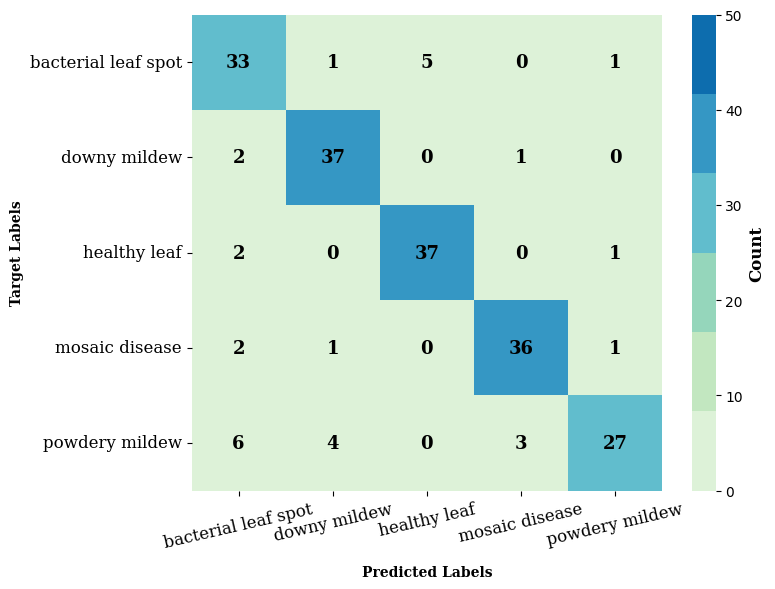

In [45]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8,6))
# Define the custom palette
custom_palette = sns.color_palette(palette='GnBu')# Modify the number based on number of classes in the dataset
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
font2 = {'family': 'Serif', 'weight': 'bold', 'size': 10}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,vmin = 0,vmax = 50,
                      xticklabels=['bacterial leaf spot', 'downy mildew', 'healthy leaf', 'mosaic disease', 'powdery mildew'], 
                      yticklabels=['bacterial leaf spot', 'downy mildew', 'healthy leaf', 'mosaic disease', 'powdery mildew'],
                      annot_kws={"family": "Serif", 'color':'black','weight': 'bold', 'size': 13})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font2)
heatmap.set_ylabel('Target Labels', fontdict=font2)


# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.set_label('Count', fontdict=font)
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space
plt.xticks(rotation=13)
plt.yticks(rotation=0)
# Adjust layout to prevent cropping
plt.tight_layout()
plt.savefig('DenseNet121.pdf')  # Save as pdf format
plt.show()


In [39]:
# from sklearn.metrics import confusion_matrix, accuracy_score
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Generate confusion matrix
# conf_matrix = confusion_matrix(true_classes, predicted_classes)

# # Calculate accuracy
# #accuracy = accuracy_score(test_labels, predicted_labels)
# #accuracy_percentage = accuracy * 100

# # Plot confusion matrix
# plt.figure(figsize=(6, 4))
# # Define the custom palette
# custom_palette = sns.light_palette("seagreen", as_cmap=True)
# # Define custom font dictionary for title and labels
# font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
# font2 = {'family': 'Serif', 'weight': 'bold', 'size': 10}

# # Create heatmap with annotations and colormap
# heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
#                       xticklabels=['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'], 
#                       yticklabels=['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],
#                       annot_kws={"family": "Serif", 'color':'black','weight': 'bold', 'size': 13})

# # Set x and y labels with the custom font dictionary
# heatmap.set_xlabel('Predicted Labels', fontdict=font2)
# heatmap.set_ylabel('Target Labels', fontdict=font2)
# #heatmap.set_title('Fundus Image Classification\nAccuracy: {:.2f}%'.format(accuracy_percentage),fontdict=font, pad=12)

# # Set font properties for tick labels on both axes
# heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
# heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# # Create a color bar to indicate the scale
# cbar = heatmap.collections[0].colorbar
# cbar.ax.tick_params(labelsize=10)
# # Adjust padding between x-axis label and x-axis ticks
# plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.tight_layout()

# plt.savefig('D:\Data\\InceptionResNetV2__confusion_matrix.pdf')  # Save as pdf format
# plt.show()


# **ROC curve for DensNet121**

In [40]:
# from sklearn.metrics import roc_curve, roc_auc_score
# import matplotlib.pyplot as plt
# from matplotlib.patches import Patch


# # Assuming predicted probabilities for the "Fractured" class (class index 1)
# positive_class_prob = predictions[:, 0]  # Adjust the index based on the column containing the probabilities
#  # Replace 1 with the appropriate index for the "Fractured" class

# # Calculate ROC curve and AUC score
# fpr, tpr, thresholds = roc_curve(true_classes, positive_class_prob)
# roc_auc = roc_auc_score(true_classes, positive_class_prob)


# # Define custom font dictionary for title and labels
# font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# # Plot ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Baseline')
# plt.xlabel('False Positive Rate', fontdict=font)
# plt.ylabel('True Positive Rate', fontdict=font)
# plt.title('Fractured Vs Non_fractured', fontdict=font, pad=12)

# # Create legend entries with bbox
# legend_handles = [
#     Patch(facecolor='blue',  label='Fractured Vs Non_fractured (AUC = %0.2f)' % roc_auc),
#     Patch(facecolor='red',  label='Baseline (AUC = 0.5)')
# ]

# # Combine loss and accuracy labels with custom legend lines and bbox
# plt.legend(handles=legend_handles, loc='lower center', ncol=1, prop={'family': 'Serif', 'weight': 'bold', 'size': 10})

# # Enable grid with customized properties
# plt.grid(True, linestyle='--', linewidth=0.7, color='gray')

# # Set x-axis ticks font properties
# plt.xticks(fontname='Serif', weight='bold')

# # Set y-axis ticks font properties
# plt.yticks(fontname='Serif', weight='bold')

# # Adjust padding between x-axis label and x-axis ticks
# plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space

# plt.show()


# **Checking model predictions for random images from test dataset**

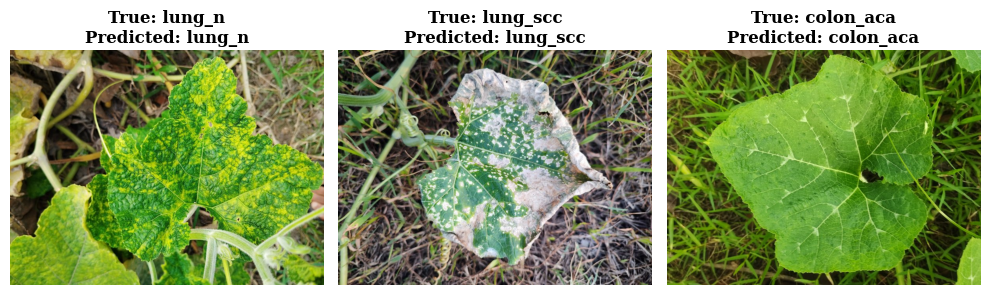

In [41]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Assuming you have true_classes and predicted_classes as lists of class indices
# For example, true_classes = [0, 1, 2, 3, 4] and predicted_classes = [0, 1, 2, 3, 4]

# Get random indices for three images
random_indices = random.sample(range(len(true_classes)), 3)

plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices, 1):
    # Load the image
    img_path = test_generator.filepaths[idx]
    img = Image.open(img_path)
    
    # Display the image
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.axis('off')

    # Display the true and predicted labels
    true_label = {
        0: 'colon_aca',
        1: 'colon_n',
        2: 'lung_aca',
        3: 'lung_n',
        4: 'lung_scc'
    }[true_classes[idx]]

    predicted_label = {
        0: 'colon_aca',
        1: 'colon_n',
        2: 'lung_aca',
        3: 'lung_n',
        4: 'lung_scc'
    }[predicted_classes[idx]]

    plt.title(f"True: {true_label}\nPredicted: {predicted_label}", fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})

plt.tight_layout()
plt.show()


# **No. 1 : Explainable AI (GradCAM)**
### **Step 1:** Prepare the Model (We've done it already)
### **Step 2:** Load and Preprocess an Image (We'll need an image to visualize the Grad-CAM heatmap)
### **Step 3:** Get the Class Activation Map (CAM) (We'll create a function to generate the Grad-CAM heatmap using the model we've built)

# **Function for displaying GradCAM images**

In [42]:
# Function to save and display GradCAM
def save_and_display_gradcam(img_path, heatmap, alpha=0.7):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_PLASMA)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('GradCAM', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('/kaggle/working/InceptionResNetV2_gradcam.pdf')  # Save as pdf formatD:\\Data\\EfficientNetB4_gradcam_plusplus.pdf
    plt.show()



# **GradCAM function**
### **Gradient Calculation:** Using these activations, GradCAM computes the gradients of the predicted class's score with respect to the feature maps. These gradients indicate the importance of each feature map in determining the final class prediction.

### **Global Average Pooling (GAP):** GradCAM takes the gradients and performs Global Average Pooling (GAP) across the spatial dimensions of each feature map. This step generates a weight for each feature map, reflecting its relevance to the predicted class.

### **Weighted Combination:** GradCAM computes a weighted combination of the feature maps based on their importance weights obtained from GAP. This combination highlights the regions in the feature maps that strongly influence the predicted class.

### **Heatmap Generation:** The weighted combination produces a heatmap by overlaying these selected regions back onto the input image. The heatmap visually demonstrates which parts of the image are pivotal in the model's decision-making for the predicted class.

In [43]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



# **Visualization of Grad-Cam**

In [44]:
 # make a prediction and visualize grad-cam
def make_prediction_and_visualize_():
    img_path = '/kaggle/working/test/Mosaic Disease/Mosaic Disease (50).jpg'

    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299)) #IMG_WIDTH, IMG_HEIGHT
    rescaled_img = img/255.0
    batch_pred = np.expand_dims(rescaled_img, 0)


    last_conv_layer_name = 'conv_7b_ac'

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_gradcam(img_path, heatmap)


make_prediction_and_visualize_()

ValueError: No such layer: conv_7b_ac. Existing layers are: ['input_layer', 'zero_padding2d', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'zero_padding2d_1', 'pool1', 'conv2_block1_0_bn', 'conv2_block1_0_relu', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_concat', 'conv2_block2_0_bn', 'conv2_block2_0_relu', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_concat', 'conv2_block3_0_bn', 'conv2_block3_0_relu', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_concat', 'conv2_block4_0_bn', 'conv2_block4_0_relu', 'conv2_block4_1_conv', 'conv2_block4_1_bn', 'conv2_block4_1_relu', 'conv2_block4_2_conv', 'conv2_block4_concat', 'conv2_block5_0_bn', 'conv2_block5_0_relu', 'conv2_block5_1_conv', 'conv2_block5_1_bn', 'conv2_block5_1_relu', 'conv2_block5_2_conv', 'conv2_block5_concat', 'conv2_block6_0_bn', 'conv2_block6_0_relu', 'conv2_block6_1_conv', 'conv2_block6_1_bn', 'conv2_block6_1_relu', 'conv2_block6_2_conv', 'conv2_block6_concat', 'pool2_bn', 'pool2_relu', 'pool2_conv', 'pool2_pool', 'conv3_block1_0_bn', 'conv3_block1_0_relu', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_concat', 'conv3_block2_0_bn', 'conv3_block2_0_relu', 'conv3_block2_1_conv', 'conv3_block2_1_bn', 'conv3_block2_1_relu', 'conv3_block2_2_conv', 'conv3_block2_concat', 'conv3_block3_0_bn', 'conv3_block3_0_relu', 'conv3_block3_1_conv', 'conv3_block3_1_bn', 'conv3_block3_1_relu', 'conv3_block3_2_conv', 'conv3_block3_concat', 'conv3_block4_0_bn', 'conv3_block4_0_relu', 'conv3_block4_1_conv', 'conv3_block4_1_bn', 'conv3_block4_1_relu', 'conv3_block4_2_conv', 'conv3_block4_concat', 'conv3_block5_0_bn', 'conv3_block5_0_relu', 'conv3_block5_1_conv', 'conv3_block5_1_bn', 'conv3_block5_1_relu', 'conv3_block5_2_conv', 'conv3_block5_concat', 'conv3_block6_0_bn', 'conv3_block6_0_relu', 'conv3_block6_1_conv', 'conv3_block6_1_bn', 'conv3_block6_1_relu', 'conv3_block6_2_conv', 'conv3_block6_concat', 'conv3_block7_0_bn', 'conv3_block7_0_relu', 'conv3_block7_1_conv', 'conv3_block7_1_bn', 'conv3_block7_1_relu', 'conv3_block7_2_conv', 'conv3_block7_concat', 'conv3_block8_0_bn', 'conv3_block8_0_relu', 'conv3_block8_1_conv', 'conv3_block8_1_bn', 'conv3_block8_1_relu', 'conv3_block8_2_conv', 'conv3_block8_concat', 'conv3_block9_0_bn', 'conv3_block9_0_relu', 'conv3_block9_1_conv', 'conv3_block9_1_bn', 'conv3_block9_1_relu', 'conv3_block9_2_conv', 'conv3_block9_concat', 'conv3_block10_0_bn', 'conv3_block10_0_relu', 'conv3_block10_1_conv', 'conv3_block10_1_bn', 'conv3_block10_1_relu', 'conv3_block10_2_conv', 'conv3_block10_concat', 'conv3_block11_0_bn', 'conv3_block11_0_relu', 'conv3_block11_1_conv', 'conv3_block11_1_bn', 'conv3_block11_1_relu', 'conv3_block11_2_conv', 'conv3_block11_concat', 'conv3_block12_0_bn', 'conv3_block12_0_relu', 'conv3_block12_1_conv', 'conv3_block12_1_bn', 'conv3_block12_1_relu', 'conv3_block12_2_conv', 'conv3_block12_concat', 'pool3_bn', 'pool3_relu', 'pool3_conv', 'pool3_pool', 'conv4_block1_0_bn', 'conv4_block1_0_relu', 'conv4_block1_1_conv', 'conv4_block1_1_bn', 'conv4_block1_1_relu', 'conv4_block1_2_conv', 'conv4_block1_concat', 'conv4_block2_0_bn', 'conv4_block2_0_relu', 'conv4_block2_1_conv', 'conv4_block2_1_bn', 'conv4_block2_1_relu', 'conv4_block2_2_conv', 'conv4_block2_concat', 'conv4_block3_0_bn', 'conv4_block3_0_relu', 'conv4_block3_1_conv', 'conv4_block3_1_bn', 'conv4_block3_1_relu', 'conv4_block3_2_conv', 'conv4_block3_concat', 'conv4_block4_0_bn', 'conv4_block4_0_relu', 'conv4_block4_1_conv', 'conv4_block4_1_bn', 'conv4_block4_1_relu', 'conv4_block4_2_conv', 'conv4_block4_concat', 'conv4_block5_0_bn', 'conv4_block5_0_relu', 'conv4_block5_1_conv', 'conv4_block5_1_bn', 'conv4_block5_1_relu', 'conv4_block5_2_conv', 'conv4_block5_concat', 'conv4_block6_0_bn', 'conv4_block6_0_relu', 'conv4_block6_1_conv', 'conv4_block6_1_bn', 'conv4_block6_1_relu', 'conv4_block6_2_conv', 'conv4_block6_concat', 'conv4_block7_0_bn', 'conv4_block7_0_relu', 'conv4_block7_1_conv', 'conv4_block7_1_bn', 'conv4_block7_1_relu', 'conv4_block7_2_conv', 'conv4_block7_concat', 'conv4_block8_0_bn', 'conv4_block8_0_relu', 'conv4_block8_1_conv', 'conv4_block8_1_bn', 'conv4_block8_1_relu', 'conv4_block8_2_conv', 'conv4_block8_concat', 'conv4_block9_0_bn', 'conv4_block9_0_relu', 'conv4_block9_1_conv', 'conv4_block9_1_bn', 'conv4_block9_1_relu', 'conv4_block9_2_conv', 'conv4_block9_concat', 'conv4_block10_0_bn', 'conv4_block10_0_relu', 'conv4_block10_1_conv', 'conv4_block10_1_bn', 'conv4_block10_1_relu', 'conv4_block10_2_conv', 'conv4_block10_concat', 'conv4_block11_0_bn', 'conv4_block11_0_relu', 'conv4_block11_1_conv', 'conv4_block11_1_bn', 'conv4_block11_1_relu', 'conv4_block11_2_conv', 'conv4_block11_concat', 'conv4_block12_0_bn', 'conv4_block12_0_relu', 'conv4_block12_1_conv', 'conv4_block12_1_bn', 'conv4_block12_1_relu', 'conv4_block12_2_conv', 'conv4_block12_concat', 'conv4_block13_0_bn', 'conv4_block13_0_relu', 'conv4_block13_1_conv', 'conv4_block13_1_bn', 'conv4_block13_1_relu', 'conv4_block13_2_conv', 'conv4_block13_concat', 'conv4_block14_0_bn', 'conv4_block14_0_relu', 'conv4_block14_1_conv', 'conv4_block14_1_bn', 'conv4_block14_1_relu', 'conv4_block14_2_conv', 'conv4_block14_concat', 'conv4_block15_0_bn', 'conv4_block15_0_relu', 'conv4_block15_1_conv', 'conv4_block15_1_bn', 'conv4_block15_1_relu', 'conv4_block15_2_conv', 'conv4_block15_concat', 'conv4_block16_0_bn', 'conv4_block16_0_relu', 'conv4_block16_1_conv', 'conv4_block16_1_bn', 'conv4_block16_1_relu', 'conv4_block16_2_conv', 'conv4_block16_concat', 'conv4_block17_0_bn', 'conv4_block17_0_relu', 'conv4_block17_1_conv', 'conv4_block17_1_bn', 'conv4_block17_1_relu', 'conv4_block17_2_conv', 'conv4_block17_concat', 'conv4_block18_0_bn', 'conv4_block18_0_relu', 'conv4_block18_1_conv', 'conv4_block18_1_bn', 'conv4_block18_1_relu', 'conv4_block18_2_conv', 'conv4_block18_concat', 'conv4_block19_0_bn', 'conv4_block19_0_relu', 'conv4_block19_1_conv', 'conv4_block19_1_bn', 'conv4_block19_1_relu', 'conv4_block19_2_conv', 'conv4_block19_concat', 'conv4_block20_0_bn', 'conv4_block20_0_relu', 'conv4_block20_1_conv', 'conv4_block20_1_bn', 'conv4_block20_1_relu', 'conv4_block20_2_conv', 'conv4_block20_concat', 'conv4_block21_0_bn', 'conv4_block21_0_relu', 'conv4_block21_1_conv', 'conv4_block21_1_bn', 'conv4_block21_1_relu', 'conv4_block21_2_conv', 'conv4_block21_concat', 'conv4_block22_0_bn', 'conv4_block22_0_relu', 'conv4_block22_1_conv', 'conv4_block22_1_bn', 'conv4_block22_1_relu', 'conv4_block22_2_conv', 'conv4_block22_concat', 'conv4_block23_0_bn', 'conv4_block23_0_relu', 'conv4_block23_1_conv', 'conv4_block23_1_bn', 'conv4_block23_1_relu', 'conv4_block23_2_conv', 'conv4_block23_concat', 'conv4_block24_0_bn', 'conv4_block24_0_relu', 'conv4_block24_1_conv', 'conv4_block24_1_bn', 'conv4_block24_1_relu', 'conv4_block24_2_conv', 'conv4_block24_concat', 'pool4_bn', 'pool4_relu', 'pool4_conv', 'pool4_pool', 'conv5_block1_0_bn', 'conv5_block1_0_relu', 'conv5_block1_1_conv', 'conv5_block1_1_bn', 'conv5_block1_1_relu', 'conv5_block1_2_conv', 'conv5_block1_concat', 'conv5_block2_0_bn', 'conv5_block2_0_relu', 'conv5_block2_1_conv', 'conv5_block2_1_bn', 'conv5_block2_1_relu', 'conv5_block2_2_conv', 'conv5_block2_concat', 'conv5_block3_0_bn', 'conv5_block3_0_relu', 'conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_1_relu', 'conv5_block3_2_conv', 'conv5_block3_concat', 'conv5_block4_0_bn', 'conv5_block4_0_relu', 'conv5_block4_1_conv', 'conv5_block4_1_bn', 'conv5_block4_1_relu', 'conv5_block4_2_conv', 'conv5_block4_concat', 'conv5_block5_0_bn', 'conv5_block5_0_relu', 'conv5_block5_1_conv', 'conv5_block5_1_bn', 'conv5_block5_1_relu', 'conv5_block5_2_conv', 'conv5_block5_concat', 'conv5_block6_0_bn', 'conv5_block6_0_relu', 'conv5_block6_1_conv', 'conv5_block6_1_bn', 'conv5_block6_1_relu', 'conv5_block6_2_conv', 'conv5_block6_concat', 'conv5_block7_0_bn', 'conv5_block7_0_relu', 'conv5_block7_1_conv', 'conv5_block7_1_bn', 'conv5_block7_1_relu', 'conv5_block7_2_conv', 'conv5_block7_concat', 'conv5_block8_0_bn', 'conv5_block8_0_relu', 'conv5_block8_1_conv', 'conv5_block8_1_bn', 'conv5_block8_1_relu', 'conv5_block8_2_conv', 'conv5_block8_concat', 'conv5_block9_0_bn', 'conv5_block9_0_relu', 'conv5_block9_1_conv', 'conv5_block9_1_bn', 'conv5_block9_1_relu', 'conv5_block9_2_conv', 'conv5_block9_concat', 'conv5_block10_0_bn', 'conv5_block10_0_relu', 'conv5_block10_1_conv', 'conv5_block10_1_bn', 'conv5_block10_1_relu', 'conv5_block10_2_conv', 'conv5_block10_concat', 'conv5_block11_0_bn', 'conv5_block11_0_relu', 'conv5_block11_1_conv', 'conv5_block11_1_bn', 'conv5_block11_1_relu', 'conv5_block11_2_conv', 'conv5_block11_concat', 'conv5_block12_0_bn', 'conv5_block12_0_relu', 'conv5_block12_1_conv', 'conv5_block12_1_bn', 'conv5_block12_1_relu', 'conv5_block12_2_conv', 'conv5_block12_concat', 'conv5_block13_0_bn', 'conv5_block13_0_relu', 'conv5_block13_1_conv', 'conv5_block13_1_bn', 'conv5_block13_1_relu', 'conv5_block13_2_conv', 'conv5_block13_concat', 'conv5_block14_0_bn', 'conv5_block14_0_relu', 'conv5_block14_1_conv', 'conv5_block14_1_bn', 'conv5_block14_1_relu', 'conv5_block14_2_conv', 'conv5_block14_concat', 'conv5_block15_0_bn', 'conv5_block15_0_relu', 'conv5_block15_1_conv', 'conv5_block15_1_bn', 'conv5_block15_1_relu', 'conv5_block15_2_conv', 'conv5_block15_concat', 'conv5_block16_0_bn', 'conv5_block16_0_relu', 'conv5_block16_1_conv', 'conv5_block16_1_bn', 'conv5_block16_1_relu', 'conv5_block16_2_conv', 'conv5_block16_concat', 'bn', 'relu', 'flatten', 'dense'].

# **No. 2 : Explainable AI (GradCAM++)**
### **Step 1:** Prepare the Model (We've done it already)
### **Step 2:** Load and Preprocess an Image (We'll need an image to visualize the Grad-CAM++ heatmap)
### **Step 3:** Get the Class Activation Map (CAM) (We'll create a function to generate the Grad-CAM++ heatmap using the model we've built)


In [ ]:
# Function to save and display ScoreCAM
def save_and_display_gradcam_plusplus(img_path, heatmap, alpha=0.7):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_PLASMA)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('GradCAM++', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('D:\\Data\\Lung_InceptionResNetV2__gradcam_plusplus.pdf')  # Save as pdf format
    plt.show()



# **GradCAM++ function**
### **Gradient Computation:** Derive gradients between predicted class and conv layer's output, indicating feature map importance.
### **Positive and Negative Gradients:** Split gradients into positive (activating) and negative (inhibiting) parts, signifying influential and counteractive regions.
### **Weighting and Aggregation:** Calculate separate importance weights from positive and negative gradients, combining them to determine feature map significance.
### **Weighted Sum and Heatmap:** Blend positive and negative weights to generate a weighted sum, utilized for heatmap creation, pinpointing significant regions contributing to the predicted class.

In [ ]:
# Function to generate GradCAM++ heatmap
def make_gradcam_plusplus_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]
        conv_output = last_conv_layer_output[0]

    # Get gradients
    grads = tape.gradient(class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads[0], axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]

    # Calculate guided gradients
    guided_grads = tf.cast(last_conv_layer_output > 0, 'float32') * grads[0]

    # Calculate importance weights
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # Generate heatmap
    heatmap = tf.reduce_sum(tf.multiply(weights, last_conv_layer_output), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)  # Normalize

    return heatmap.numpy()


# **Visualization of Grad-Cam++**

In [ ]:
# Function to make a prediction and visualize GradCAM++
def make_prediction_and_visualize_gradcam_plusplus():
    img_path = 'D:\\Our Future works\\lung_colon_image_\\Test\\colon_n\\colonn5.jpeg'


    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299))  # Resize image to match model input size
    rescaled_img = img / 255.0
    batch_pred = np.expand_dims(rescaled_img, 0)

    last_conv_layer_name = 'conv5_block16_concat'

    # Generate GradCAM++ heatmap
    heatmap = make_gradcam_plusplus_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_gradcam_plusplus(img_path, heatmap)

make_prediction_and_visualize_gradcam_plusplus()

# **No. 3 : Explainable AI (ScoreCAM)**
### **Step 1:** Prepare the Model (We've done it already)
### **Step 2:** Load and Preprocess an Image (We'll need an image to visualize the Score-CAM heatmap)
### **Step 3:** Get the Class Activation Map (CAM) (We'll create a function to generate the Score-CAM heatmap using the model we've built)


In [ ]:
# Function to save and display ScoreCAM
def save_and_display_scorecam(img_path, heatmap, alpha=0.7):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_PLASMA)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the ScoreCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('ScoreCAM', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('D:\\Data\\Lung_InceptionResNetV2__scorecam.pdf')  # Save as pdf format
    plt.show()



# **ScoreCAM function**
### **Gradient Computation:** Score-CAM calculates the gradients of the predicted class score with respect to the output feature maps, just like Grad-CAM. These gradients provide information about the importance of each feature map in the predicted class's activation.
### **Guided Gradients:** Instead of considering positive and negative gradients separately, Score-CAM utilizes guided gradients to focus only on positive gradients, i.e., gradients that have a positive influence on the predicted class. This step enhances the saliency of the significant regions.
### **Global Average Pooling (GAP):** Score-CAM performs Global Average Pooling (GAP) across the spatial dimensions of the guided gradients to generate importance weights for each feature map, indicating their relevance to the predicted class.
### **Score-weighted Activation Map:** The technique computes a score-weighted activation map by multiplying the weights obtained from GAP with the feature maps and summing across channels. This highlights the regions in the feature maps that contribute the most to the predicted class, emphasizing the most discriminative areas in the input image.

In [ ]:
import tensorflow as tf

def make_scorecam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]
        conv_output = last_conv_layer_output[0]

    # Get the gradients of the predicted class with respect to the output feature map
    grads = tape.gradient(class_output, last_conv_layer_output)
    guided_grads = tf.cast(grads[0] > 0, 'float32') * grads[0]

    # GAP (Global Average Pooling) along the spatial dimensions
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # Calculate the score-weighted activation map
    cam = tf.reduce_sum(tf.multiply(weights, conv_output), axis=-1)
    cam = tf.maximum(cam, 0)  # ReLU to ensure non-negativity
    cam /= tf.reduce_max(cam)  # Normalize

    return cam.numpy()


# **Visualization of ScoreCam**

In [ ]:
# make a prediction and visualize ScoreCAM
def make_prediction_and_visualize_scorecam():
    img_path = 'D:\\Our Future works\\lung_colon_image_\\Test\\colon_n\\colonn5.jpeg'


    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299)) #IMG_WIDTH, IMG_HEIGHT
    rescaled_img = img/255.0
    batch_pred = np.expand_dims(rescaled_img, 0)

    last_conv_layer_name = 'conv5_block16_concat'

    # Generate class activation heatmap
    heatmap = make_scorecam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_scorecam(img_path, heatmap)

make_prediction_and_visualize_scorecam()


# **No. 4 : Explainable AI (Faster Score-CAM)**
### **step 1:** Prepare the Model (We've done it already)
### **Step 2:** Load and Preprocess an Image (We'll need an image to visualize the Faster Score-CAM heatmap)
### **Step 3:** Get the Class Activation Map (CAM) (We'll create a function to generate the Faster Score-CAM heatmap using the model we've built)


# **Function for displaying Original and Faster ScoreCAM images**

In [ ]:
# Function to save and display Faster ScoreCAM
def save_and_display_faster_scorecam(img_path, heatmap, alpha=0.7):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_PLASMA)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the Faster ScoreCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Faster ScoreCAM', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('D:\\Data\\Lung_InceptionResNetV2_faster_scorecam.pdf')  # Save as pdf format
    plt.show()



# **Faster ScoreCAM function**
### **Gradient Calculation:** Using a GradientTape, it computes the gradients of the predicted class output with respect to the output feature map of the specified last convolutional layer.

### **Global Average Pooling (GAP):** The gradients obtained are subjected to Global Average Pooling (GAP) along the spatial dimensions, resulting in weights representing the importance of each feature map in the predicted class's activation.

### **Weighted Sum Calculation:** Reshaping the obtained weights and the convolutional output, the function performs matrix multiplication between them, efficiently obtaining a score-weighted activation map that highlights significant regions related to the predicted class.

###  **Normalization and ReLU:** The resulting score-weighted activation map is normalized and subjected to ReLU (Rectified Linear Unit) activation, ensuring non-negativity and scaling to highlight the most influential regions.

In [ ]:
def faster_scorecam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]
        conv_output = last_conv_layer_output[0]

    # Get the gradient of the predicted class with respect to the output feature map
    grads = tape.gradient(class_output, last_conv_layer_output)[0]

    # Global average pooling (GAP) to compute weights
    weights = tf.reduce_mean(grads, axis=(0, 1))

    # Reshape the weights to perform matrix multiplication with the convolutional output
    weights = tf.reshape(weights, (1, 1, -1))

    # Reshape conv_output to match the dimensions for matrix multiplication
    conv_output = tf.expand_dims(conv_output, axis=0)
    conv_output = tf.expand_dims(conv_output, axis=-1)  # Add a new dimension for matrix multiplication

    # Calculate the score-weighted activation map efficiently
    cam = tf.matmul(weights, conv_output)
    cam = tf.squeeze(cam)
    cam = tf.maximum(cam, 0)  # ReLU to ensure non-negativity
    cam /= tf.reduce_max(cam)  # Normalize

    return cam.numpy()


# **Visualization of faster ScoreCam**

In [ ]:
# make a prediction and visualize Faster ScoreCAM
def make_prediction_and_visualize_faster_scorecam():
    img_path = 'D:\\Our Future works\\lung_colon_image_\\Test\\colon_n\\colonn5.jpeg'


    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299)) #IMG_WIDTH, IMG_HEIGHT
    rescaled_img = img/255.0
    batch_pred = np.expand_dims(rescaled_img, 0)

    last_conv_layer_name = 'conv5_block16_concat'

    # Generate class activation heatmap
    heatmap = faster_scorecam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_faster_scorecam(img_path, heatmap)

make_prediction_and_visualize_faster_scorecam()


# **No. 5 : Explainable AI (LayerCAM)**

### **Step 1:** Prepare the Model (We've done it already)
### **Step 2:** Load and Preprocess an Image (We'll need an image to visualize the LayerCAM heatmap)
### **Step 3:** Get the Class Activation Map (CAM) (We'll create a function to generate the LayerCAM heatmap using the model we've built)

# **Function for displaying Original and LayerCAM images**

In [ ]:
# Function to save and display layercam
def save_and_display_layercam(img_path, heatmap, alpha=0.7):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_PLASMA)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('LayerCAM', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('D:\\Data\\Lung_InceptionResNetV2_layercam.pdf')  # Save as pdf format
    plt.show()



# **LayerCAM function**
###  **Gradient Calculation:** Utilize a gradient tape to compute gradients of the predicted class score with respect to the output feature maps obtained from the chosen layer.

###  **Global Average Pooling (GAP):** Perform Global Average Pooling across the spatial dimensions of the gradients to generate importance weights for each feature map.

### **Weight Reshaping:** Reshape the obtained weights to fit the required dimensions for subsequent matrix multiplication.

### **Activation Map Computation:** Compute a score-weighted activation map by performing a matrix multiplication between the reshaped weights and the output feature maps from the chosen layer.

### **Activation Map Adjustment:** Apply Rectified Linear Unit (ReLU) to ensure non-negativity in the heatmap.

### **Normalization:** Normalize the heatmap to ensure that the values fall within a certain range, often between 0 and 1, which aids in visualization.

In [ ]:
import tensorflow as tf

def generate_layercam_heatmap(img_array, model, last_conv_layer_name, target_class_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if target_class_index is None:
            target_class_index = tf.argmax(preds[0])
        class_output = preds[:, target_class_index]
        conv_output = last_conv_layer_output[0]

    # Calculate gradients of the predicted class with respect to the output feature map
    grads = tape.gradient(class_output, last_conv_layer_output)[0]

    # Global average pooling (GAP) to compute weights
    weights = tf.reduce_mean(grads, axis=(0, 1))

    # Reshape the weights to perform matrix multiplication with the convolutional output
    weights = tf.reshape(weights, (1, 1, -1))

    # Expand dimensions of conv_output for matrix multiplication
    conv_output = tf.expand_dims(conv_output, axis=0)
    conv_output = tf.expand_dims(conv_output, axis=-1)  # Add a new dimension for matrix multiplication

    # Calculate the score-weighted activation map (LayerCAM)
    cam = tf.matmul(weights, conv_output)
    cam = tf.squeeze(cam)
    cam = tf.maximum(cam, 0)  # ReLU to ensure non-negativity
    cam /= tf.reduce_max(cam)  # Normalize

    return cam.numpy()


# **Visualization of LayerCAM**

In [ ]:
# make a prediction and visualize layercam
def make_prediction_and_visualize_layercam():
    img_path = 'D:\\Our Future works\\lung_colon_image_\\Test\\colon_n\\colonn5.jpeg'

    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299))#IMG_WIDTH, IMG_HEIGHT
    rescaled_img = img/255.0
    batch_pred = np.expand_dims(rescaled_img, 0)

    last_conv_layer_name = 'conv5_block16_concat'

    # Generate class activation heatmap
    heatmap = generate_layercam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_layercam(img_path, heatmap)


make_prediction_and_visualize_layercam()

# **No. 6 : Explainable AI (Vanilla Saliency)**
### **Step 1:** Prepare the Model (We've done it already)
### **Step 2:** Load and Preprocess an Image (We'll need an image to visualize the Vanilla Saliency heatmap)
### **Step 3:** Get the Saliency Maps (We'll create a function to generate the Vanilla Saliency heatmap using the model we've built)


In [ ]:
def save_and_display_saliency_map(img_path, saliency_map):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    saliency_map = cv2.resize(saliency_map, (img.shape[1], img.shape[0]))
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * saliency_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    alpha = 0.4
    blended = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)


    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(blended)
    plt.title('Vanilla Saliency', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('D:\\Data\\Lung_InceptionResNetV2_vanilla_saliency.pdf')
    plt.show()


# **Saliency Map function**
### **Gradient Calculation:** Calculate the gradients of the predicted class's score concerning these feature maps. These gradients illustrate how changes in the feature maps affect the model's confidence in predicting a specific class. Higher gradients indicate more critical regions within the feature maps.

### **Importance Weighting through Global Average Pooling (GAP):** Apply Global Average Pooling across each feature map's spatial dimensions. This step calculates the importance weight assigned to each feature map in influencing the predicted class. The weights reflect the significance of each feature map's contribution.

### **Weighted Combination:** Create a weighted combination of the feature maps based on the importance weights obtained from the Global Average Pooling step. This combination emphasizes the regions within the feature maps that strongly impact the model's decision for the predicted class.

In [ ]:
def generate_vanilla_saliency_map(img_array, model):
    img_tensor = tf.convert_to_tensor(img_array)
    img_tensor = tf.expand_dims(img_tensor, axis=0)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        top_pred_index = tf.argmax(preds[0])

        # Get the predicted score for the highest probability class
        top_class_score = preds[:, top_pred_index]

    # Compute the gradients of the top class score with respect to the input image
    grads = tape.gradient(top_class_score, img_tensor)
    saliency_map = tf.abs(grads)
    saliency_map = tf.reduce_max(saliency_map, axis=-1)

    return saliency_map[0].numpy()

# **Visualization of Saliency Map**

In [ ]:

# make a prediction and visualize Vanilla Saliency
def make_prediction_and_visualize_vanilla_saliency():
    img_path = 'D:\\Our Future works\\lung_colon_image_\\Test\\colon_n\\colonn5.jpeg'   

   # Read the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))  # Resize the image to match model input size

    # Preprocess the image (normalize pixel values)
    img = img / 255.0
    


    # Generate class activation heatmap
    saliency_map = generate_vanilla_saliency_map(img, loaded_model)

    
# Display the saliency map overlay
    save_and_display_saliency_map(img_path, saliency_map)

make_prediction_and_visualize_vanilla_saliency()

# **No. 7 : Explainable AI (SmoothGrad)**
### **Step 1:** Prepare the Model (We've done it already)
### **Step 2:** Load and Preprocess an Image (We'll need an image to visualize the SmoothGrad heatmap)
### **Step 3:** Get the Saliency Maps (We'll create a function to generate the SmoothGrad heatmap using the model we've built)

# **Function for displaying SmoothGrad images**

In [ ]:
def save_and_display_SmoothGrad(img_path, saliency_map):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    saliency_map = cv2.resize(saliency_map, (img.shape[1], img.shape[0]))
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * saliency_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    alpha = 0.4
    blended = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)


    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(blended)
    plt.title('Smooth Grad', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('D:\\Data\\Lung_InceptionResNetV2_smooth_grad.pdf')
    plt.show()



# **SmoothGrad function**
### **Model Prediction:** Use a pre-trained model to make predictions on the input image. Retrieve the index corresponding to the highest predicted class probability.

### **Gradient Accumulation:** Initialize a tensor for accumulating gradients (total_gradients). Repeat the process n times:

a. Generate a perturbed version of the input image by adding Gaussian noise (noise) to the original image tensor.

b. Compute the model's predictions on the perturbed image and obtain the class score for the top predicted class.

c. Calculate the gradients of the top class score with respect to the perturbed image.

d. Accumulate the gradients obtained from each perturbed image into total_gradients.

### **Average Gradients:** Divide total_gradients by the total number of perturbed images (n) to obtain averaged gradients (averaged_gradients). These averaged gradients represent the average sensitivity of the model's predictions to perturbations in each pixel of the input image.

### **Saliency Map Generation:** Calculate the absolute values of the averaged gradients, take the maximum across the color channels, and obtain the saliency map by reducing the tensor to a single channel (2D) image.



In [ ]:
def generate_smoothgrad_saliency_map(img_array, model, n=50, sigma=1.0):
    img_tensor = tf.convert_to_tensor(img_array)
    img_tensor = tf.expand_dims(img_tensor, axis=0)
    img_tensor = tf.cast(img_tensor, dtype=tf.float32)  # Convert to float32

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        top_pred_index = tf.argmax(preds[0])

        # Get the predicted score for the highest probability class
        top_class_score = preds[:, top_pred_index]

    total_gradients = tf.zeros_like(img_tensor)  # Initialize total gradients

    for _ in range(n):
        # Create perturbed versions of the input image with Gaussian noise
        noise = tf.random.normal(shape=img_tensor.shape, mean=0.0, stddev=sigma)
        perturbed_img = img_tensor + noise

        # Compute gradients for perturbed image
        with tf.GradientTape() as perturbed_tape:
            perturbed_tape.watch(perturbed_img)
            perturbed_preds = model(perturbed_img)
            perturbed_top_class_score = perturbed_preds[:, top_pred_index]

        # Compute gradients of the top class score w.r.t. perturbed image
        perturbed_grads = perturbed_tape.gradient(perturbed_top_class_score, perturbed_img)

        # Accumulate gradients
        total_gradients += perturbed_grads

    # Average gradients over perturbed images
    averaged_gradients = total_gradients / n

    saliency_map = tf.abs(averaged_gradients)
    saliency_map = tf.reduce_max(saliency_map, axis=-1)

    return saliency_map[0].numpy()

# **Visualization of SmoothGrad**

In [ ]:
def make_prediction_and_visualize_smoothgrad_saliency():
    img_path = 'D:\\Our Future works\\lung_colon_image_\\Test\\colon_n\\colonn5.jpeg'


    # Read the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))  # Resize the image to match model input size

    # Preprocess the image (normalize pixel values)
    img = img / 255.0



    # Generate SmoothGrad saliency map
    heatmap = generate_smoothgrad_saliency_map(img, loaded_model)

    # Display the saliency map overlay
    save_and_display_SmoothGrad(img_path, heatmap)


# Assuming loaded_model and other necessary components are defined
make_prediction_and_visualize_smoothgrad_saliency()

